In [1]:
from IPython.display import clear_output

import pandas as pd
import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

## Get the test files

In [2]:
with open('D:/AlgoMLData/Risk/lgbm_test_set', 'rb') as file:
    test_set = joblib.load(file)

In [3]:
test_set.shape

(46481, 29)

In [4]:
## Order by the tickers
test_set.sort_values('Ticker', inplace=True)

In [5]:
## Set aside half of the data
np.random.seed(72)
idc = np.random.permutation(test_set.shape[0])
idx = int(0.5 * len(idc))
train = test_set.iloc[idc[:idx], :]
test = test_set.iloc[idc[idx:], :]

In [6]:
train.shape

(23240, 29)

### Load all the raw data files 

In [7]:
tickers = {}
for file in os.listdir('D:/TickData_Agg/'):
    tickers[file[:-4]] = pd.read_csv('D:/TickData_Agg/{}'.format(file))

In [8]:
tickers.keys()

dict_keys(['AUDJPY', 'AUDNZD', 'AUDUSD', 'CADJPY', 'CHFJPY', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'GBPJPY', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY'])

### Get 100 Candles for each trade

In [9]:
## Tick Increments
tick_increments = {
    "EURCHF" : 0.00005,
    "USDCHF" : 0.00005,
    "GBPUSD" : 0.00005,
    "USDJPY" : 0.005,
    "EURUSD" : 0.00005,
    "EURGBP" : 0.00005,
    "NZDUSD" : 0.00005,
    "USDCAD" : 0.00005,
    "EURJPY" : 0.005,
    "AUDUSD" : 0.00005,
    "GBPJPY" : 0.005,
    "CHFJPY" : 0.005,
    "AUDNZD" : 0.00005,
    "AUDJPY" : 0.005,
    "CADJPY" : 0.005
}

In [10]:
main = []
for ticker in tickers:
    print(ticker)
    
    ## Get the raw
    raw = tickers[ticker][['Datetime', 'Open', 'High', 'Low', 'Close']]
    raw['Ticker'] = ticker
    
    ## Get the trades
    trades = train[train.Ticker == ticker].sort_values('Datetime')
    raw_trades = raw[raw.Datetime.isin(trades.Datetime.values)]
    dts = raw_trades.Datetime.values
    directions = trades[trades.Datetime.isin(dts)].Direction
    raw_trades['Direction'] = directions
    
    ## Get the candle progressions
    idc = raw_trades.index.values
    idc = [np.arange(idx, idx+101).tolist() for idx in idc]
    dfs = [raw.iloc[idx, :] for idx in idc if idx[-1] in raw.index.values]
    [df.insert(5, 'Direction', dir_) for df, dir_ in zip(dfs, directions)]
    
    ## Extend to main
    main.extend(dfs)

AUDJPY


C:\Users\Zach\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Zach\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AUDNZD
AUDUSD
CADJPY
CHFJPY
EURCHF
EURGBP
EURJPY
EURUSD
GBPJPY
GBPUSD
NZDUSD
USDCAD
USDCHF
USDJPY


In [11]:
## Sanity check over all trades
for df in main:
    if df.Datetime.values[0] not in train.Datetime.values and df.Direction.values[0] != -1 * np.sign(df.Close.values[0] - df.Open.values[0]):
        1/0

In [12]:
for df in main:
    if df.Direction.nunique() != 1:
        1/0

In [13]:
## No error means we have the first candle of every trade

### Calculate the drawdowns and candle sizes for each of the dataframes

In [14]:
trades_concat = pd.concat(main, axis=0)

In [15]:
## Compute the candle size values
trades_concat['Anchor'] = np.array([[trades_concat.Close.values[i]]*101 for i in range(0, len(trades_concat), 101)]).reshape(-1, )
trades_concat['CandleSize'] = abs(np.array([[trades_concat.Close.values[i] - trades_concat.Open.values[i]]*101 for i in range(0, len(trades_concat), 101)]).reshape(-1, ))
trades_concat['CandleSize'] = [cs / tick_increments[ticker] for cs, ticker in zip(trades_concat.CandleSize, trades_concat.Ticker)]

In [16]:
## Compute the max risk per trade
trades_concat['MaxRisk'] = trades_concat.CandleSize.values * 2.5

In [17]:
## Compute the drawdown or run up for each trade
trades_concat.head()

,Datetime,Open,High,Low,Close,Direction,Ticker,Anchor,CandleSize,MaxRisk
1206,2009-05-05 04:30:00,72.890,73.1480,72.8515,73.1240,-1.0,AUDJPY,73.124,46.8,117.0
1207,2009-05-05 04:35:00,73.122,73.1310,73.0675,73.1270,-1.0,AUDJPY,73.124,46.8,117.0
1208,2009-05-05 04:40:00,73.130,73.1315,73.0495,73.1125,-1.0,AUDJPY,73.124,46.8,117.0
1209,2009-05-05 04:45:00,73.114,73.2605,73.1125,73.2465,-1.0,AUDJPY,73.124,46.8,117.0
1210,2009-05-05 04:50:00,73.246,73.2665,73.1770,73.1790,-1.0,AUDJPY,73.124,46.8,117.0


In [18]:
drawdowns = (trades_concat.Direction * (trades_concat.Close - trades_concat.Anchor)).values
drawdowns[drawdowns > 0] = 0
trades_concat['Drawdown'] = drawdowns
trades_concat['Drawdown'] = [dd / tick_increments[ticker] for dd, ticker in zip(trades_concat.Drawdown, trades_concat.Ticker)]

In [19]:
runups = (trades_concat.Direction * (trades_concat.Close - trades_concat.Anchor)).values
runups[runups < 0] = 0
trades_concat['RunUp'] = runups
trades_concat['RunUp'] = [ru / tick_increments[ticker] for ru, ticker in zip(trades_concat.RunUp, trades_concat.Ticker)]

In [20]:
longs = (trades_concat.High - trades_concat.Anchor).values
shorts = (trades_concat.Anchor - trades_concat.Low).values

In [21]:
max_runup = [max(0, longs[i]) if dir_ == 1 else max(0, shorts[i]) for i, dir_ in enumerate(trades_concat.Direction.values)]
trades_concat['MRunUp'] = max_runup
trades_concat['MRunUp'] = [mru / tick_increments[ticker] for mru, ticker in zip(trades_concat.MRunUp, trades_concat.Ticker)]

In [22]:
trades_concat['Drawdown'] = trades_concat.Drawdown / trades_concat.MaxRisk
trades_concat['RunUp'] = trades_concat.RunUp / trades_concat.CandleSize
trades_concat['MRunUp'] = trades_concat.MRunUp / trades_concat.CandleSize

In [23]:
## Represent it as a percentage format
trades_concat.head(10)

,Datetime,Open,High,Low,Close,Direction,Ticker,Anchor,CandleSize,MaxRisk,Drawdown,RunUp,MRunUp
1206,2009-05-05 04:30:00,72.8900,73.1480,72.8515,73.1240,-1.0,AUDJPY,73.124,46.8,117.0,-0.000000,-0.000000,1.164530
1207,2009-05-05 04:35:00,73.1220,73.1310,73.0675,73.1270,-1.0,AUDJPY,73.124,46.8,117.0,-0.005128,0.000000,0.241453
1208,2009-05-05 04:40:00,73.1300,73.1315,73.0495,73.1125,-1.0,AUDJPY,73.124,46.8,117.0,0.000000,0.049145,0.318376
1209,2009-05-05 04:45:00,73.1140,73.2605,73.1125,73.2465,-1.0,AUDJPY,73.124,46.8,117.0,-0.209402,0.000000,0.049145
1210,2009-05-05 04:50:00,73.2460,73.2665,73.1770,73.1790,-1.0,AUDJPY,73.124,46.8,117.0,-0.094017,0.000000,0.000000
1211,2009-05-05 04:55:00,73.1770,73.1790,73.0525,73.0645,-1.0,AUDJPY,73.124,46.8,117.0,0.000000,0.254274,0.305556
1212,2009-05-05 05:00:00,73.0625,73.0935,72.9885,73.0935,-1.0,AUDJPY,73.124,46.8,117.0,0.000000,0.130342,0.579060
1213,2009-05-05 05:05:00,73.0980,73.1810,73.0980,73.1695,-1.0,AUDJPY,73.124,46.8,117.0,-0.077778,0.000000,0.111111
1214,2009-05-05 05:10:00,73.1670,73.1680,73.0205,73.0730,-1.0,AUDJPY,73.124,46.8,117.0,0.000000,0.217949,0.442308
1215,2009-05-05 05:15:00,73.0720,73.0890,73.0275,73.0620,-1.0,AUDJPY,73.124,46.8,117.0,0.000000,0.264957,0.412393


In [24]:
## Break the trades back into small pieces
trades_ind = np.split(trades_concat, len(trades_concat) / 101)

### See how many trades run up after the signal

In [25]:
all_the_same = []
close_over = []
wick_to_close = []
stop_outs = []
close_and_wick = []

## Filter any trades that are less than 10$

for i, trade in enumerate(trades_ind):
    
    if trade.iloc[0, :].CandleSize >= 10:
    
        full_trade = trade.copy()
        trade = trade.iloc[1:, :]

        ## Get closing winners
        idx_close = trade[trade.RunUp > 1].index.values
        idx_close = min(idx_close) if len(idx_close) != 0 else 10e6

        ## Get wicking winners
        idx_wick = trade[trade.MRunUp > 1].index.values
        idx_wick = min(idx_wick) if len(idx_wick) != 0 else 10e6

        ## Get losers
        idx_lost = trade[trade.Drawdown < -1].index.values
        idx_lost = min(idx_lost) if len(idx_lost) != 0 else 10e6

        ## Loser
        if idx_lost < idx_close and idx_lost < idx_wick:
            stop_outs.append(full_trade)
        ## Close over
        elif idx_close == idx_wick and idx_wick < idx_lost:
            close_over.append(full_trade)
        ## Wick closed
        elif idx_wick < idx_close and idx_wick < idx_lost:
            wick_to_close.append(full_trade)
        elif idx_wick == idx_close and idx_wick == idx_lost:
            all_the_same.append(full_trade)
        elif idx_wick == idx_lost and idx_wick < idx_close:
            close_and_wick.append(full_trade)
        else:
            print(idx_wick, idx_close, idx_lost)

In [26]:
len(trades_ind)

23215

In [27]:
len(all_the_same)

2769

In [28]:
len(close_and_wick)

10

In [29]:
len(stop_outs)

3493

In [30]:
len(close_over)

6262

In [31]:
len(wick_to_close)

6670

In [32]:
## Look at the number of trades that go back under the the limit
## Look at the distribution of the margin of closes

### Look at the distribution of candle sizes per category 

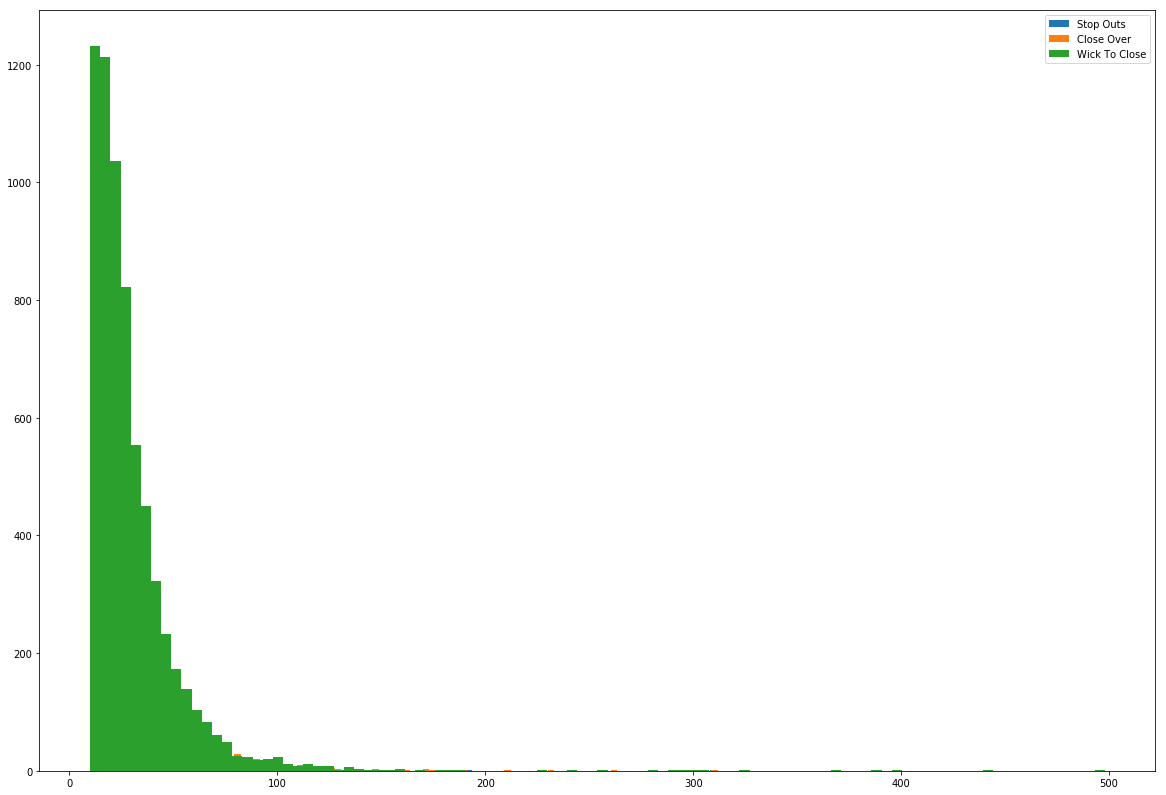

In [33]:
plt.figure(figsize=(20, 14))
plt.hist([df.iloc[0, :].CandleSize for df in stop_outs], bins=100, label='Stop Outs')
plt.hist([df.iloc[0, :].CandleSize for df in close_over], bins=100, label='Close Over')
plt.hist([df.iloc[0, :].CandleSize for df in wick_to_close], bins=100, label='Wick To Close')
plt.legend()
plt.show()

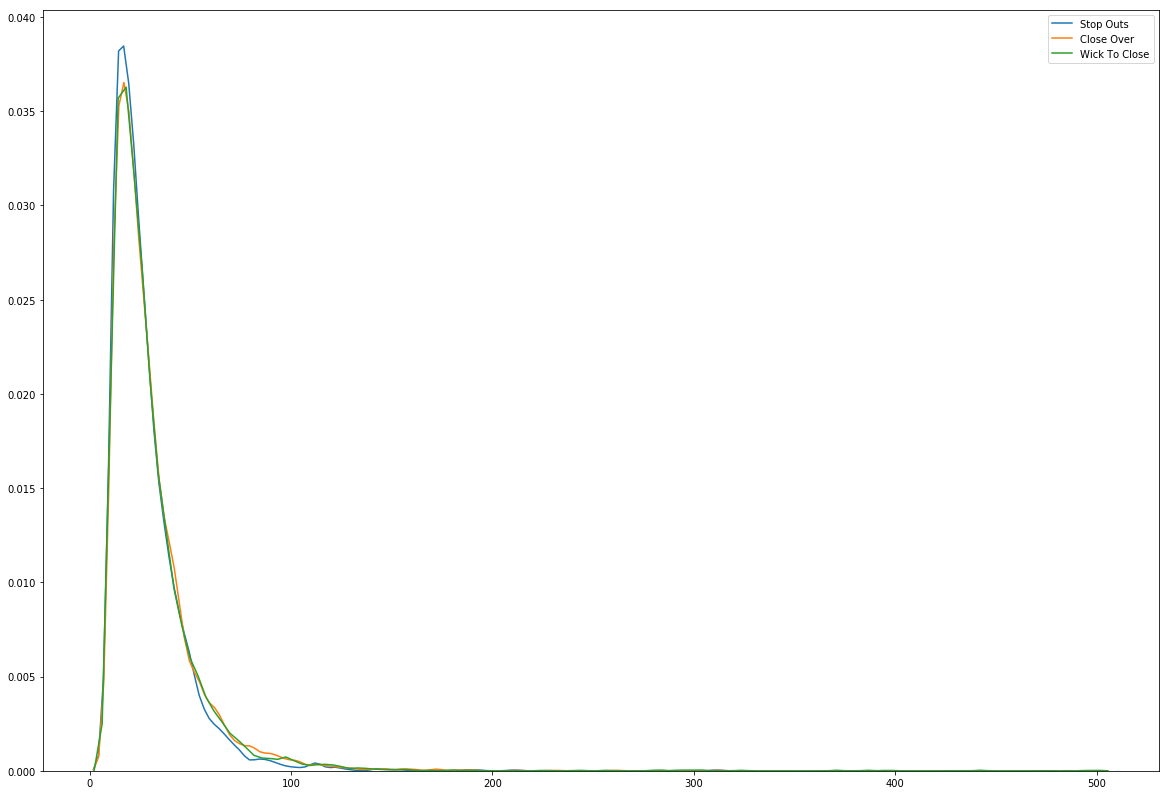

In [34]:
plt.figure(figsize=(20, 14))
sns.kdeplot([df.iloc[0, :].CandleSize for df in stop_outs],label='Stop Outs')
sns.kdeplot([df.iloc[0, :].CandleSize for df in close_over], label='Close Over')
sns.kdeplot([df.iloc[0, :].CandleSize for df in wick_to_close], label='Wick To Close')
plt.legend()
plt.show()

### Candle Sizes

In [35]:
candles = [trade.iloc[0, :].CandleSize for trade in trades_ind]

In [36]:
pd.Series(candles).describe()

count    23215.000000
mean        28.592724
std         38.953574
min          0.000000
25%         12.800000
50%         21.800000
75%         35.600000
max       4029.200000
dtype: float64

### Distribution of margins - On close over

In [37]:
len(close_over)

6262

In [38]:
margins = []
progressions = []

for trade in close_over:
    
    idx = trade[trade.RunUp > 1].index.values[0]
    margins.append(trade.loc[idx, :].RunUp - 1)
    
    progressions.append(trade.loc[idx:, :].RunUp.values.tolist())

In [39]:
max_size = max([len(prog) for prog in progressions])
max_size

100

In [40]:
candle_bins = []
for i in range(100):
    candle_bins.append([np.nan_to_num(prog[i]) for prog in progressions if len(prog) > i and prog[i] != np.inf])

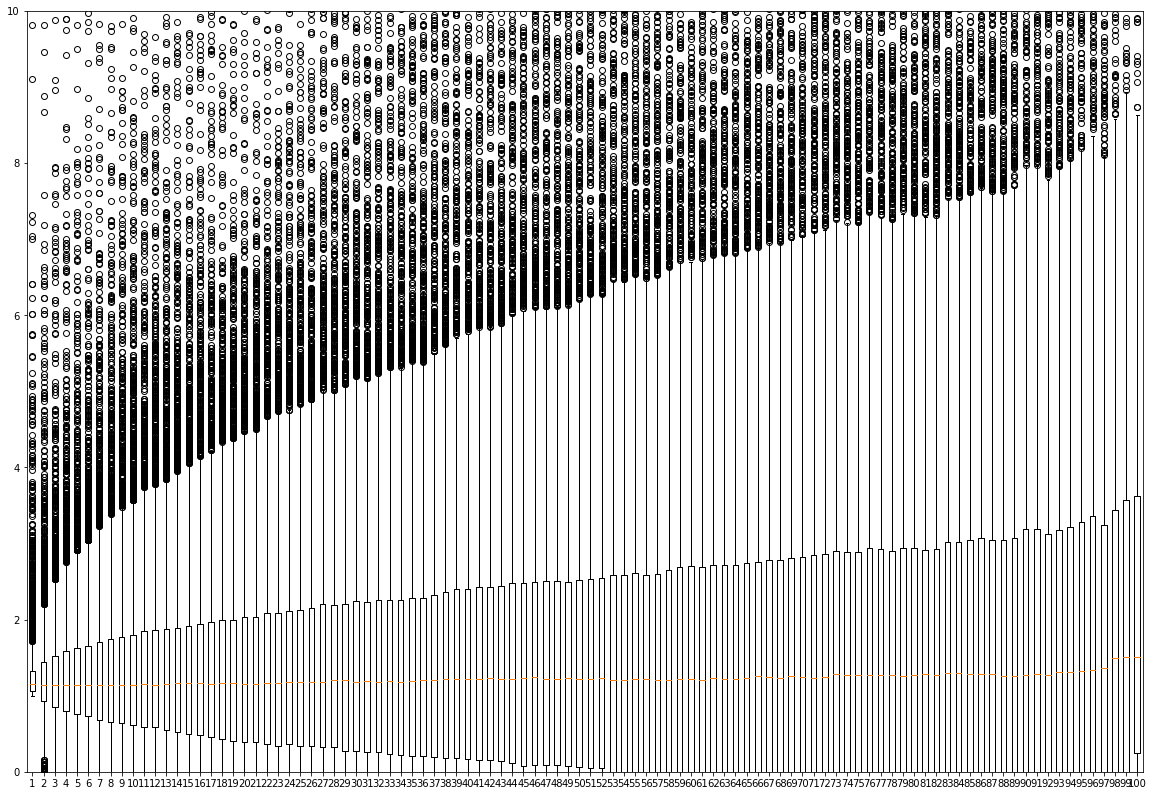

In [41]:
plt.figure(figsize=(20, 14))
plt.ylim(0, 10)
plt.boxplot(candle_bins)
plt.show()

### Check for those that close over, the ROC of the next candle

In [42]:
candles = []
rocs = []

for trade in close_over:
    
    idx = trade[trade.RunUp > 1].index.values[0]
    closer = trade.loc[idx, :].RunUp
    try:
        next_candle = trade.loc[idx:idx+2, :].RunUp
        roc = (next_candle.mean() - closer) / closer
        candles.append(closer)
        rocs.append(roc)
    except:
        pass

In [43]:
df = pd.DataFrame(list(zip(candles, rocs)), columns = ['Candle', 'ROC'])

In [44]:
df.corr()

,Candle,ROC
Candle,1.000000,0.018687
ROC,0.018687,1.000000


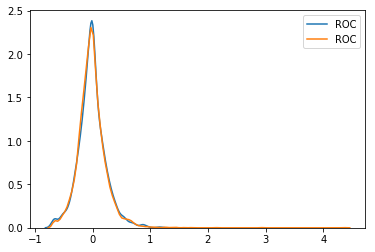

In [45]:
sns.kdeplot(df[df.Candle >= 1.5].ROC)
sns.kdeplot(df.ROC)

### Check how many of those that wick to close get stopped out 

In [46]:
stop_before = []
close_before = []
all_the_same = []

for trade in wick_to_close:
    
    full_trade = trade.copy()
    trade = trade.iloc[1:, :]
    
    idx_wick = trade[trade.MRunUp > 1].index.values[0]
    trade = trade.loc[idx_wick:, :]
    
    idx_close = trade[trade.RunUp > 1].index.values
    idx_close = min(idx_close) if len(idx_close) != 0 else 10e6
    
    idx_lost = trade[trade.Drawdown < -0.5].index.values
    idx_lost = min(idx_lost) if len(idx_lost) != 0 else 10e6
    
    if idx_lost < idx_close:
        
        stop_before.append(full_trade)
    
    elif idx_close < idx_lost:
        
        close_before.append(full_trade)
    
    else:
        
        all_the_same.append(full_trade)

In [47]:
len(wick_to_close)

6670

In [48]:
len(stop_before), len(close_before), len(all_the_same)

(926, 5323, 421)

In [49]:
len(wick_to_close)

6670

### Get the average margins

In [50]:
margins = []

for trade in close_before:
    
    idx_close = trade[trade.RunUp > 1].index.values[0]
    margins.append(trade.loc[idx_close, :].RunUp)
    
for trade in close_and_wick:
    idx_close = trade[trade.RunUp < 1].index.values[0]
    margins.append(trade.loc[idx_close, :].RunUp)

In [51]:
pd.Series(margins).describe()

count    5333.000000
mean        1.247091
std         0.501525
min        -0.000000
25%         1.059801
50%         1.146597
75%         1.301496
max        17.547619
dtype: float64

In [52]:
lower = np.quantile(margins, 0.01)
upper = np.quantile(margins, 0.99)

In [53]:
margins = pd.Series(margins)

In [54]:
margins = margins[(margins >= lower) & (margins <= upper)]

In [55]:
margins.describe()

count    5225.000000
mean        1.221564
std         0.231505
min         1.003589
25%         1.061136
50%         1.146597
75%         1.295580
max         2.453901
dtype: float64

In [56]:
### Average margin we make for letting it close it 22%

In [57]:
### For those that wick above, we take a 50% smaller loss than usual.
### The ones that do close under are only 14% of the trades.

### Downside margin

In [58]:
margins = []
for trade in stop_outs:
    idx_close = trade[trade.Drawdown < -1].index.values[0]
    margins.append(trade.loc[idx_close, :].Drawdown)

In [59]:
half_margins = []
for trade in stop_before:
    
    full_trade = trade.copy()
    trade = trade.iloc[1:, :]
    
    idx_wick = trade[trade.MRunUp > 1].index.values[0]
    trade = trade.loc[idx_wick:, :]
    
    idx_wick = trade[trade.Drawdown < -0.5].index.values[0]
    half_margins.append(trade.loc[idx_wick, :].Drawdown)

In [60]:
len(half_margins)

926

In [61]:
margins = pd.Series(margins)
half_margins = pd.Series(half_margins)

In [62]:
margins.describe()

count    3493.000000
mean       -1.157796
std         0.327364
min        -8.410909
25%        -1.172571
50%        -1.081728
75%        -1.034965
max        -1.000000
dtype: float64

In [63]:
lower = np.quantile(margins, 0.01)
upper = np.quantile(margins, 0.99)
margins = margins[(margins >= lower) & (margins <= upper)]

In [64]:
margins.describe()

count    3423.000000
mean       -1.135731
std         0.164552
min        -2.308370
25%        -1.169504
50%        -1.081728
75%        -1.035940
max        -1.001113
dtype: float64

In [65]:
half_margins.describe()

count    926.000000
mean      -0.639790
std        0.215295
min       -4.215707
25%       -0.671418
50%       -0.582448
75%       -0.534742
max       -0.500334
dtype: float64

In [66]:
lower = np.quantile(half_margins, 0.01)
upper = np.quantile(half_margins, 0.99)
half_margins = half_margins[(half_margins >= lower) & (half_margins <= upper)]

In [67]:
half_margins.describe()

count    906.000000
mean      -0.626509
std        0.133861
min       -1.328926
25%       -0.669196
50%       -0.582448
75%       -0.535342
max       -0.501667
dtype: float64

### Determine if you sell on close OR hold under certain conditions

In [68]:
progs = []
candle_sizes = []

for trade in close_over:
    
    idx_close = trade[trade.RunUp > 1].index.values[0]
    trade = trade.loc[idx_close:, :]
    
    candle_sizes.append(trade.RunUp.values[0])
    progs.append((trade.RunUp.pct_change() + 1).cumprod())

In [69]:
max_5_progs = [np.mean(np.nan_to_num(p[1:15])) for p in progs if len(p) > 1]
candle_sizes_5 = [cs for p, cs in zip(progs, candle_sizes) if len(p) > 1]

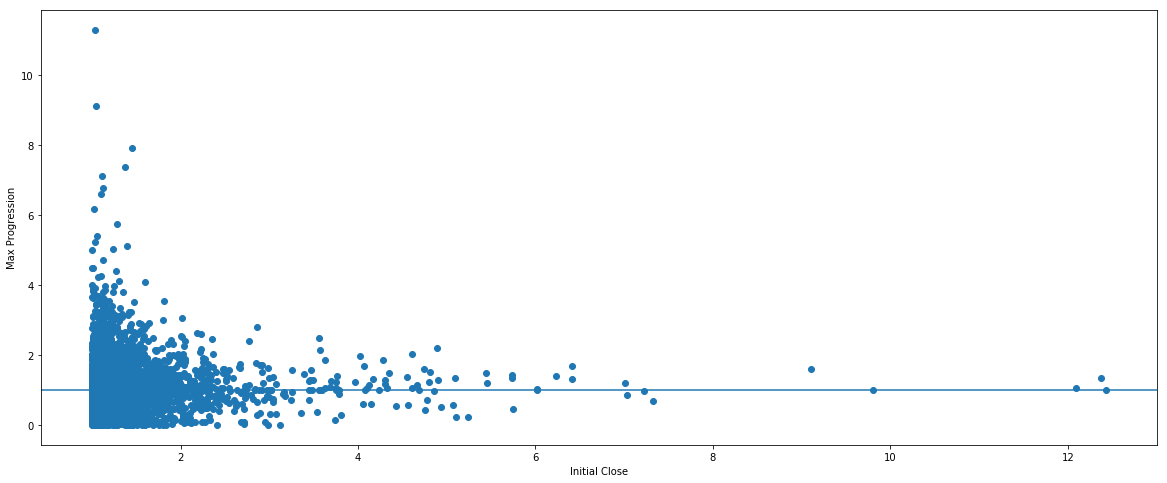

In [70]:
plt.figure(figsize=(20, 8))
plt.scatter(candle_sizes_5, max_5_progs)
plt.xlabel('Initial Close')
plt.ylabel('Max Progression')
plt.axhline(1)
plt.show()

In [71]:
## I dont think there's anything much we can do at this point.
## Maybe we develop something afterwards that gets more profit if we see it through. E.v of 60c is great.

### Check the average TTC of each of the trades

In [103]:
ttcs_close_over = []
for trade in close_over:
    
    idx_close = trade[trade.RunUp > 1].index.values[0]
    ttcs_close_over.append(trade.loc[:idx_close, :].shape[0] - 1)

In [81]:
ttcs_close_before = []
for trade in close_before:
    
    idx_close = trade[trade.RunUp > 1].index.values[0]
    ttcs_close_before.append(trade.loc[:idx_close, :].shape[0] - 1)

In [82]:
ttcs_stop_out = []
for trade in stop_outs:
    idx_close = trade[trade.Drawdown < -1].index.values[0]
    ttcs_stop_out.append(trade.loc[:idx_close, :].shape[0] - 1)

In [96]:
ttcs_stop_before = []
for trade in stop_before:
    
    full_trade = trade.copy()
    trade = trade.iloc[1:, :]
    
    idx_wick = trade[trade.MRunUp > 1].index.values[0]
    trade = trade.loc[idx_wick:, :]
    try:
        idx_close = trade[trade.Drawdown < -0.5].index.values[0]
        ttcs_stop_before.append(full_trade.loc[:idx_close, :].shape[0] - 1)
    except Exception as e:
        pass

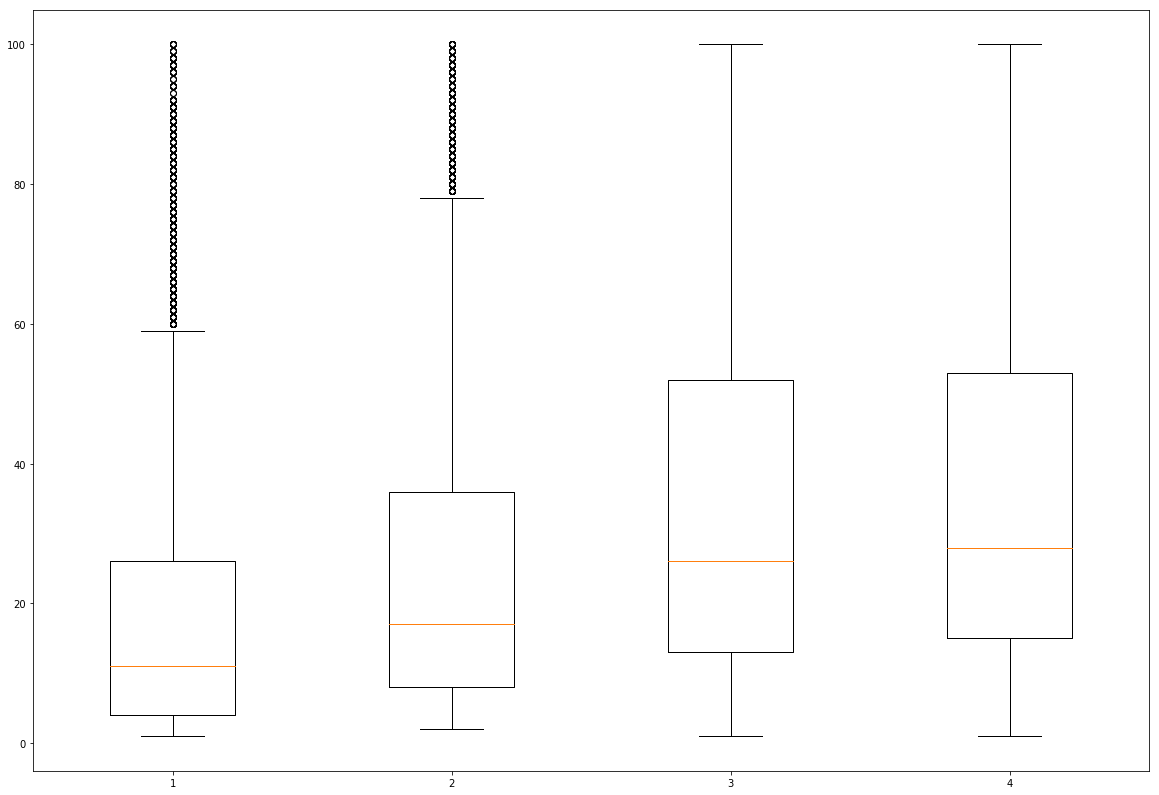

In [104]:
plt.figure(figsize=(20, 14))
plt.boxplot([ttcs_close_over, ttcs_close_before, ttcs_stop_out, ttcs_stop_before])
plt.show()

### Check the average drawdown of those after 20 ttc

In [170]:
ttc_thold = 20

In [171]:
close_over_drawdowns = []
for trade in close_over:
    
    idx_close = trade[trade.RunUp > 1].index.values[0]
    close_over_drawdowns.append(trade.loc[trade.index.values[0]+ttc_thold:idx_close, :].Drawdown.values.tolist())

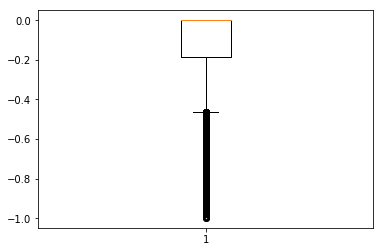

In [172]:
close_over_dds_flat = [item for sublist in close_over_drawdowns for item in sublist]
plt.boxplot(close_over_dds_flat)
plt.show()

In [173]:
lost = []
remains = []
for trade in close_over_drawdowns:
    
    if len(trade) != 0:
        
        trade = np.array(trade)
        
        if trade[trade < -0.5].shape[0] != 0:
            lost.append(trade)

In [174]:
len(lost)

368

In [148]:
ttcs_close_before_drawdown = []
for trade in close_before:
    
    idx_close = trade[trade.RunUp > 1].index.values[0]
    ttcs_close_before_drawdown.append(trade.loc[trade.index.values[0]+ttc_thold:idx_close, :].Drawdown.values.tolist())

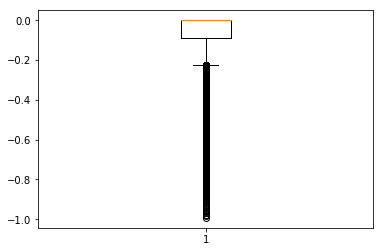

In [149]:
close_before_dds_flat = [item for sublist in ttcs_close_before_drawdown for item in sublist]
plt.boxplot(close_before_dds_flat)
plt.show()

In [ ]:
lost = []
remains = []
for trade in close_over_drawdowns:
    
    if len(trade) != 0:
        
        trade = np.array(trade)
        
        if trade[trade < -0.5].shape[0] != 0:
            lost.append(trade)

### Stop outs

In [166]:
stop_out_dds = []
for trade in stop_outs:
    
    idx_close = trade[trade.Drawdown < -1].index.values[0]
    trade = trade.loc[trade.index.values[0] + 20 : idx_close, :]
    
    stop_out_dds.append(trade.Drawdown.values.tolist())

In [167]:
len([d for d in stop_out_dds if len(d) != 0])

2121

In [169]:
2121 / len(stop_out_dds)

0.6072144288577155

In [175]:
len(stop_out_dds), 2121

(3493, 2121)

In [176]:
368, len(close_over)

(368, 6262)

### Test set results 

In [177]:
main = []
for ticker in tickers:
    print(ticker)
    
    ## Get the raw
    raw = tickers[ticker][['Datetime', 'Open', 'High', 'Low', 'Close']]
    raw['Ticker'] = ticker
    
    ## Get the trades
    trades = test[test.Ticker == ticker].sort_values('Datetime')
    raw_trades = raw[raw.Datetime.isin(trades.Datetime.values)]
    dts = raw_trades.Datetime.values
    directions = trades[trades.Datetime.isin(dts)].Direction
    raw_trades['Direction'] = directions
    
    ## Get the candle progressions
    idc = raw_trades.index.values
    idc = [np.arange(idx, idx+101).tolist() for idx in idc]
    dfs = [raw.iloc[idx, :] for idx in idc if idx[-1] in raw.index.values]
    [df.insert(5, 'Direction', dir_) for df, dir_ in zip(dfs, directions)]
    
    ## Extend to main
    main.extend(dfs)

AUDJPY


C:\Users\Zach\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Zach\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AUDNZD
AUDUSD
CADJPY
CHFJPY
EURCHF
EURGBP
EURJPY
EURUSD
GBPJPY
GBPUSD
NZDUSD
USDCAD
USDCHF
USDJPY


In [178]:
## Sanity check over all trades
for df in main:
    if df.Datetime.values[0] not in test.Datetime.values and df.Direction.values[0] != -1 * np.sign(df.Close.values[0] - df.Open.values[0]):
        1/0

In [179]:
for df in main:
    if df.Direction.nunique() != 1:
        1/0

In [180]:
## No error means we have the first candle of every trade

### Calculate the drawdowns and candle sizes for each of the dataframes

In [181]:
trades_concat = pd.concat(main, axis=0)

In [182]:
## Compute the candle size values
trades_concat['Anchor'] = np.array([[trades_concat.Close.values[i]]*101 for i in range(0, len(trades_concat), 101)]).reshape(-1, )
trades_concat['CandleSize'] = abs(np.array([[trades_concat.Close.values[i] - trades_concat.Open.values[i]]*101 for i in range(0, len(trades_concat), 101)]).reshape(-1, ))
trades_concat['CandleSize'] = [cs / tick_increments[ticker] for cs, ticker in zip(trades_concat.CandleSize, trades_concat.Ticker)]

In [183]:
## Compute the max risk per trade
trades_concat['MaxRisk'] = trades_concat.CandleSize.values * 2.5

In [184]:
## Compute the drawdown or run up for each trade
trades_concat.head()

,Datetime,Open,High,Low,Close,Direction,Ticker,Anchor,CandleSize,MaxRisk
1122,2009-05-04 21:30:00,73.0385,73.2385,73.0385,73.2365,-1.0,AUDJPY,73.2365,39.6,99.0
1123,2009-05-04 21:35:00,73.2390,73.2445,73.2095,73.2150,-1.0,AUDJPY,73.2365,39.6,99.0
1124,2009-05-04 21:40:00,73.2125,73.2220,73.2005,73.2220,-1.0,AUDJPY,73.2365,39.6,99.0
1125,2009-05-04 21:45:00,73.2205,73.2205,73.1795,73.1860,-1.0,AUDJPY,73.2365,39.6,99.0
1126,2009-05-04 21:50:00,73.1860,73.2330,73.1860,73.2285,-1.0,AUDJPY,73.2365,39.6,99.0


In [185]:
drawdowns = (trades_concat.Direction * (trades_concat.Close - trades_concat.Anchor)).values
drawdowns[drawdowns > 0] = 0
trades_concat['Drawdown'] = drawdowns
trades_concat['Drawdown'] = [dd / tick_increments[ticker] for dd, ticker in zip(trades_concat.Drawdown, trades_concat.Ticker)]

In [186]:
runups = (trades_concat.Direction * (trades_concat.Close - trades_concat.Anchor)).values
runups[runups < 0] = 0
trades_concat['RunUp'] = runups
trades_concat['RunUp'] = [ru / tick_increments[ticker] for ru, ticker in zip(trades_concat.RunUp, trades_concat.Ticker)]

In [187]:
longs = (trades_concat.High - trades_concat.Anchor).values
shorts = (trades_concat.Anchor - trades_concat.Low).values

In [188]:
max_runup = [max(0, longs[i]) if dir_ == 1 else max(0, shorts[i]) for i, dir_ in enumerate(trades_concat.Direction.values)]
trades_concat['MRunUp'] = max_runup
trades_concat['MRunUp'] = [mru / tick_increments[ticker] for mru, ticker in zip(trades_concat.MRunUp, trades_concat.Ticker)]

In [189]:
trades_concat['Drawdown'] = trades_concat.Drawdown / trades_concat.MaxRisk
trades_concat['RunUp'] = trades_concat.RunUp / trades_concat.CandleSize
trades_concat['MRunUp'] = trades_concat.MRunUp / trades_concat.CandleSize

In [190]:
## Represent it as a percentage format
trades_concat.head(10)

,Datetime,Open,High,Low,Close,Direction,Ticker,Anchor,CandleSize,MaxRisk,Drawdown,RunUp,MRunUp
1122,2009-05-04 21:30:00,73.0385,73.2385,73.0385,73.2365,-1.0,AUDJPY,73.2365,39.6,99.0,-0.000000,-0.000000,1.000000
1123,2009-05-04 21:35:00,73.2390,73.2445,73.2095,73.2150,-1.0,AUDJPY,73.2365,39.6,99.0,0.000000,0.108586,0.136364
1124,2009-05-04 21:40:00,73.2125,73.2220,73.2005,73.2220,-1.0,AUDJPY,73.2365,39.6,99.0,0.000000,0.073232,0.181818
1125,2009-05-04 21:45:00,73.2205,73.2205,73.1795,73.1860,-1.0,AUDJPY,73.2365,39.6,99.0,0.000000,0.255051,0.287879
1126,2009-05-04 21:50:00,73.1860,73.2330,73.1860,73.2285,-1.0,AUDJPY,73.2365,39.6,99.0,0.000000,0.040404,0.255051
1127,2009-05-04 21:55:00,73.2260,73.2935,73.2135,73.2935,-1.0,AUDJPY,73.2365,39.6,99.0,-0.115152,0.000000,0.116162
1128,2009-05-04 22:00:00,73.2930,73.3515,73.2920,73.3515,-1.0,AUDJPY,73.2365,39.6,99.0,-0.232323,0.000000,0.000000
1129,2009-05-04 22:05:00,73.3525,73.3640,73.3305,73.3515,-1.0,AUDJPY,73.2365,39.6,99.0,-0.232323,0.000000,0.000000
1130,2009-05-04 22:10:00,73.3520,73.3545,73.3020,73.3175,-1.0,AUDJPY,73.2365,39.6,99.0,-0.163636,0.000000,0.000000
1131,2009-05-04 22:15:00,73.3180,73.3210,73.2350,73.2845,-1.0,AUDJPY,73.2365,39.6,99.0,-0.096970,0.000000,0.007576


In [191]:
## Break the trades back into small pieces
trades_ind = np.split(trades_concat, len(trades_concat) / 101)

In [203]:
success = []
loss = []
for trade in trades_ind:
    
    max_risk = 1
    
    for i, row in enumerate(trade.values[1:]):
        
        dt, open_, high, low, close, dir_, ticker, anchor, cs, mr, dd, ru, mru = row
        
        if cs < 10:
            break
        
        if i == 19 or mru > 1:
            max_risk = 0.5
        
        if ru > 1:
            success.append(ru)
            break
        elif dd < -max_risk:
            loss.append(dd)
            break

In [205]:
len(success), len(loss), len(success) / (len(success) + len(loss))

(10806, 6630, 0.6197522367515486)

In [218]:
100 * (len(success) * np.mean(success) + len(loss) * (2.5*np.mean(loss)))

136999.5653600663